# **Buidling RAG Powered Chatbot for SINES**
In this semester project we are building retreivel augmented geneartion based chatbot for School of interdisplinary engineering & sciences (SINES) for question answering. The chatbot should be able answer queries related to SINES.

**Group Members:**
1. Muhammad Faizan
2. Umme Rubab
3. Malaika Malik

Course instructor: Dr. Usman Zia

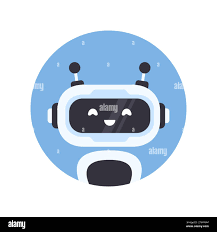

In [ ]:
%pwd
%ls

## Installation
installing all necessary packages for building the chat.
Following packages should be installed.
```
1. torch
2. datasets
3. transformers
4. tensorflow
5. langchain
6. playwright
7. html2text
8. sentence_transformers
9. faiss-cpu
10. accelerate==0.21.0
11. peft==0.4.0
12. bitsandbytes==0.40.2
13. trl==0.4.7
```




In [148]:
# run this if unix like commands are not working
import locale
locale.getdefaultlocale()


('en_US', 'UTF-8')

In [ ]:
# install all the required packages
!pip install -r requirements.txt

In [ ]:
# !pip install -q -U torch datasets transformers tensorflow langchain playwright html2text sentence_transformers faiss-cpu
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7

### import all the required packages

In [108]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline
)
from datasets import load_dataset
from peft import LoraConfig, PeftModel

from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain_community.document_loaders import PyPDFLoader

# **Using Mistal 7B Quantized model for Generation**
From Hugging Face we import our quantized Mistral-7B model:
- Outperforms Llama 2 13B on all benchmarks
- Outperforms Llama 1 34B on many benchmarks
- Approaches CodeLlama 7B performance on code, while remaining good at English tasks

set up a tokenization pipeline and loads a pre-trained language model, optionally using 4-bit precision and checking GPU compatibility for bfloat16 support.

In [ ]:
#################################################################
# Tokenizer
#################################################################

model_name='mistralai/Mistral-7B-Instruct-v0.1'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

#################################################################
# Load pre-trained config
#################################################################
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
)

### calculate number of trainable parameters in the model

In [6]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 262410240
all model parameters: 3752071168
percentage of trainable model parameters: 6.99%


### Build Mistral text generation pipeline

In [121]:
text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=1000,
    do_sample = True
)

In [122]:
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

## **Generating Response without RAG**
Let's see how our model reacts to some of questions we ask, we may see the model may not be able to caputre the following:
- no information about the recent events
- hullucinate

In [123]:
prompt_template = """
### [INST]
Instruction: Answer the question based on your
knowledge about NUST school of interdisplinary engineering & sciences (SINES):

{context}

### QUESTION:
{question}

[/INST]
 """

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

In [124]:
response = llm_chain.invoke({"context": "", "question": "where is SINES located?"})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [125]:
print(response["text"])

 The School of Interdisciplinary Engineering and Sciences (SINES) at National University of Science and Technology (NUST) is located in Islamabad, Pakistan.


In [126]:
response2 = llm_chain.invoke({"context": "", "question": "who is the principal of SINES?"})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [127]:
print(response2["text"])

 I apologize, but I do not have access to real-time information and cannot provide an answer to this question. As of my last update, the principal of NUST School of Interdisciplinary Engineering & Sciences (SINES) was Dr. Muhammad Zameer Abbas. However, it's possible that the principal has changed since then. It would be best to check with the official website or contact the university directly for the most up-to-date information.


## **RAG - Ratreivel Augmented Generation**
The generator has several problem as we saw above:
- No up to date knowledge about the subject in this case SINES
- Sometimes generate miss information or hullucinate
- Doesn't provide most precise and concise information
- May miss some important  information

Based on that we may need to add some additinonal context to the generator model to leverage the the accurate, precise, up to date, and concise knowledge to generate response. Thefore, RAG is the most optimal choice we have that takes additional context in to the account along with query in the prompt.

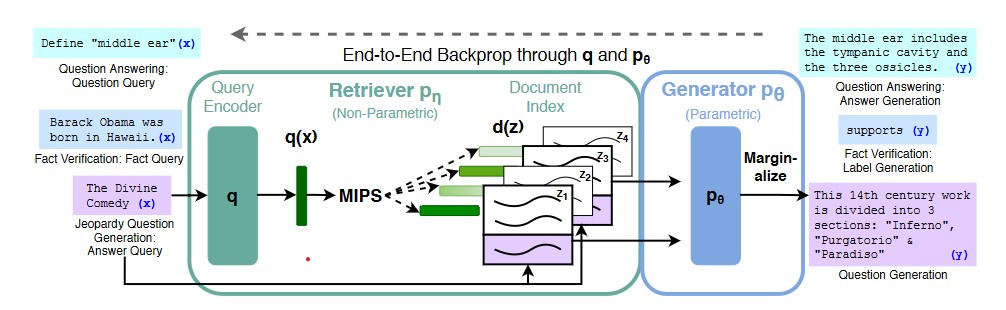

### **Document Preprocessing**
in this next cell, we get a pdf file regarding sines, we then perform following
operations on it:

- Loading the pdf file from the folder
- Splitting the document into chunks due to context window size limitation
- Creating vector database using FAISS with hugging face text embedding model
  all-mpnet-base-v2
- storing the vector database for retereival

In [120]:
doc_path = '/content/sines.txt'
if os.path.exists(doc_path):
  with open(doc_path, 'r',  encoding="utf-8") as f:
    document = f.read()
    print(document[:1000])
else:
  print('document not found')
  document = ""


Welcome to SINES
School of Interdisciplinary Engineering & Sciences is a top-notch research institute, one of its
own kinds in the country; parented by National University of Science and Technology
Islamabad. It was established in 2007 and is famous for its supercomputing facilities which
provide its technical studies with cutting edge resources. SINES NUST’s supercomputer once
made it to the list of top 500 supercomputers worldwide. Facilitated by the enabling environment
the faculty and students at SINES developed a multi-disciplinary approach to research and
education. The result oriented research by our faculty and students has made significant
contributions in the socio-economic growth of the country.
The education, training and research activities of SINES have been divided into two main
streams, namely: Computational Sciences; and Computational Engineering.
At SINES, students are encouraged and facilitated to involve themselves in specialized topics
with faculty members who are 

In [109]:
# load the document for for splitting and createing embedding
# to load pdf file
loader = PyPDFLoader("/content/sines.pdf")
docs = loader.load()


# Chunk text
text_splitter = RecursiveCharacterTextSplitter(chunk_size=600,
                                      chunk_overlap=100)
chunked_documents = text_splitter.split_documents(docs)

# Load chunked documents into the FAISS index
db = FAISS.from_documents(chunked_documents,
                          HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'))

retriever = db.as_retriever()
# retriever = db.as_retriever(
#     search_type="similarity",
#     search_kwargs={'k': 7})

In [110]:
# print some information about the document, how it was chunked.
for chunk in chunked_documents:
  print(chunk)
  print()

page_content='Welcome to SINES  \nSchool of Interdisciplinary Engineering & Sciences is a top -notch research institute, one of its \nown kinds in the country; parented by National University of Science and Technology \nIslamabad. It was established in 2007 and is famous for its supercomputing facilities which \nprovide its technical studies with cutting edge resources. SINES NUST’s supercomputer once \nmade it to the list of top 500 supercomputers worldwide. Facilitated by the enabling environment \nthe faculty and students at SINES developed a multi -disciplinary approach to research and' metadata={'source': '/content/sines.pdf', 'page': 0}

page_content='the faculty and students at SINES developed a multi -disciplinary approach to research and \neducation. The result oriented research by our faculty and students has made significant \ncontributions in the socio -economic growth of the country.  \nThe education, training and research activities of SINES have been divided into two mai

Empty GPU cache memory to avoid *OUT OF CUDA PROBLEM*

In [111]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

1629

### Building RAG Chain
we use following things to build the chain:
- reteriver (context based on the top similar documents)
- Query from the user (that will be passed later)
- And a Generator Mistal Model for response generation

In [112]:
rag_chain = (
 {"context": retriever, "question": RunnablePassthrough()}
    | llm_chain
)

# **Some Examples with RAG**
we pose some questions to the RAG based chain for answering.

In [113]:
result = rag_chain.invoke("list all the faculty members from SINES?")
print(result['text'])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


19 faculty members, including associate professors, assistant professors, RVFs and uniform faculty


In [115]:
result = rag_chain.invoke("could you provide information on SINES labs?")
print(result['text'])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Based on the given documents, SINES has several labs that fall under different themes such as materials and manufacturing, agriculture and food security, and health and well-being. The lab that falls under the health and well-being theme is the computational drug design lab, which is led by Dr. Ishrat Jabeen. It's worth noting that SINES is committed to excellence in academics and interdisciplinary research, with competent faculty and relevant equipped facilities being its key strengths. They offer current content being delivered by domain experts and have a unique faculty with a total of 19 faculty members, including associate professors, assistant professors, RVFs, and uniform faculty.


In [117]:
result = rag_chain.invoke("Who is principal of SINES?")
print(result['text'])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



The principal of SINES is Dr Hammad M. Cheema.


In [119]:
result = rag_chain.invoke("Tell me about Radar lab?")
print(result['text'])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 The Radar Research Lab falls under the theme of Sensors and Automation at the National University of Sciences and Technology (NUST) in Pakistan. It is jointly affiliated with the School of Interdisciplinary Engineering and Sciences (SINES) and the Department of Electrical and Computer Engineering (SEECS). The lab is led by Principal Investigators Dr. Hammad M. Cheema, Dr. Abid Rafique, and Dr. Umar. The lab focuses on research and development in the field of radar technology, including the design, implementation, and testing of various radar systems. Some of the projects currently being undertaken in the lab include the development of an obstacle detection and warning system for railways using microwave long-range radar, and the restoration of habitats through tree plantation using tracking portals.


# **Extending RAG to consider previous chat history**


In [75]:
from langchain.schema import format_document
from langchain_core.messages import get_buffer_string
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain.memory import ConversationBufferMemory
from langchain.prompts.prompt import PromptTemplate
from langchain_core.prompts.chat import ChatPromptTemplate

from operator import itemgetter

In [128]:
standalone_query_generation_pipeline = pipeline(
 model=model,
 tokenizer=tokenizer,
 task="text-generation",
 temperature=0.0,
 repetition_penalty=1.1,
 return_full_text=True,
 max_new_tokens=1000,
)
standalone_query_generation_llm = HuggingFacePipeline(pipeline=standalone_query_generation_pipeline)

response_generation_pipeline = pipeline(
 model=model,
 tokenizer=tokenizer,
 task="text-generation",
 temperature=0.2,
 repetition_penalty=1.1,
 return_full_text=True,
 max_new_tokens=1000,
)
response_generation_llm = HuggingFacePipeline(pipeline=response_generation_pipeline)

In [129]:
_template = """
[INST]
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language, that can be used to query a FAISS index. This query will be used to retrieve documents with additional context.

Let me share a couple examples that will be important.

If you do not see any chat history, you MUST return the "Follow Up Input" as is:

```
Chat History:

Follow Up Input: Where is SINES located?
Standalone Question:
Where is SINES located?
```

If this is the second question onwards, you should properly rephrase the question like this:

```
Chat History:
Human: Where is SINES located?
AI:
SINES is located at NUST, Islamabad Pakistan.

Follow Up Input: When was it built?
Standalone Question:
When was SINES built?
```

Now, with those examples, here is the actual chat history and input question.

Chat History:
{chat_history}

Follow Up Input: {question}
Standalone question:
[your response here]
[/INST]
"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

In [130]:
template = """
[INST]
Answer the question based only on the following context:
{context}

Question: {question}
[/INST]
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(template)

In [131]:
DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")

def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

In [132]:
# Instantiate ConversationBufferMemory
memory = ConversationBufferMemory(
 return_messages=True, output_key="answer", input_key="question"
)

# First we add a step to load memory
# This adds a "memory" key to the input object
loaded_memory = RunnablePassthrough.assign(
    chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
)
# Now we calculate the standalone question
standalone_question = {
    "standalone_question": {
        "question": lambda x: x["question"],
        "chat_history": lambda x: get_buffer_string(x["chat_history"]),
    }
    | CONDENSE_QUESTION_PROMPT
    | standalone_query_generation_llm,
}
# Now we retrieve the documents
retrieved_documents = {
    "docs": itemgetter("standalone_question") | retriever,
    "question": lambda x: x["standalone_question"],
}
# Now we construct the inputs for the final prompt
final_inputs = {
    "context": lambda x: _combine_documents(x["docs"]),
    "question": itemgetter("question"),
}
# And finally, we do the part that returns the answers
answer = {
    "answer": final_inputs | ANSWER_PROMPT | response_generation_llm,
    "question": itemgetter("question"),
    "context": final_inputs["context"]
}
# And now we put it all together!
final_chain = loaded_memory | standalone_question | retrieved_documents | answer

In [133]:
def call_conversational_rag(question, chain, memory):
    """
    Calls a conversational RAG (Retrieval-Augmented Generation) model to generate an answer to a given question.

    This function sends a question to the RAG model, retrieves the answer, and stores the question-answer pair in memory
    for context in future interactions.

    Parameters:
    question (str): The question to be answered by the RAG model.
    chain (LangChain object): An instance of LangChain which encapsulates the RAG model and its functionality.
    memory (Memory object): An object used for storing the context of the conversation.

    Returns:
    dict: A dictionary containing the generated answer from the RAG model.
    """

    # Prepare the input for the RAG model
    inputs = {"question": question}

    # Invoke the RAG model to get an answer
    result = chain.invoke(inputs)

    # Save the current question and its answer to memory for future context
    memory.save_context(inputs, {"answer": result["answer"]})

    # Return the result
    return result

In [144]:

question = "What is SINES?"
response = call_conversational_rag(question, final_chain, memory)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [143]:
print(response['answer'])

The programs offered by SINES at NUST include specialized topics in various fields such as aerospace engineering, computer science and information systems, and supercomputing research and education.


In [146]:
question = "Can you provide information about courses offered?"
response = call_conversational_rag(question, final_chain, memory)
print(response['answer'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Based on the given context, SINES offers courses in Aeronautical Engineering and Computer Science and Information Systems at NUST. However, there is no specific information provided about the courses offered by SINES. It is recommended to check the official website or contact the university directly for more details on the courses offered by SINES.
